# Matrix Factorization Recommender System

### Goal:
To create a recommender system by using gradient descent to factorize the movie ratings matrix into user and movie latent vectors.

### Data:
The data used is the small movie lens data set. 
<br>
https://grouplens.org/datasets/movielens/

## Two common techniques used for recommender systems are collaborative filtering and content filtering

### Collaborative Filtering
- create vectors for items and users from item-user interations

### Content filtering
- create vectors for items and users (e.g. using inverse word frequencies)

We will be doing matrix factorization, which is a form of collaborative filtering.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Load and investigate user-movie interaction data

In [2]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
unique_movies = ratings['movieId'].unique()
unique_users = ratings['userId'].unique()

n_users = len(unique_users)
n_movies = len(unique_movies)
print('unique users:',n_users)
print('unique_movies:',n_movies)

unique users: 610
unique_movies: 9724


In [4]:
print(max(unique_users))
print(max(unique_movies))

610
193609


#### Create a useful dictionary to navigate between indices and data

In [5]:
# this means we need to create a mapping from the movie id's to their positions in the matrix
# unique users == number of users, but we will create a mapping for them too
uid_to_idx = dict()
mvid_to_idx = dict()
idx_to_uid = dict()
idx_to_mvid = dict()

for i, uid in enumerate(unique_users):
    uid_to_idx[uid] = i
    idx_to_uid[i] = uid
    
for i, mvid in enumerate(unique_movies):
    mvid_to_idx[mvid] = i
    idx_to_mvid[i] = mvid
    


### Load and investigate movie-title data

In [6]:
# create mapping from mvid to movie name
movie_df = pd.read_csv('ml-latest-small/movies.csv')
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#### Create dictionary of (movie_id, title)

In [7]:
titles = movie_df['title'].values
mvids = movie_df['movieId'].values
n_vids = len(mvids)
mvid_to_title = dict()

for i in range(n_vids):
    mvid_to_title[mvids[i]] = titles[i] 



In [8]:
# Assume user-movie non-interaction is a 0 rating
np_data = np.zeros((n_users, n_movies))

In [9]:
np_data.shape

(610, 9724)

In [10]:
np_data[0][0]

0.0

In [11]:
print(np_data[0])
print(np_data[0][0])

[0. 0. 0. ... 0. 0. 0.]
0.0


In [12]:
# populate the data
for i in range(n_users):
    uid = idx_to_uid.get(i)
    # get all movieId
    user_i = ratings[ratings['userId'] == uid]
    movies = user_i['movieId'].values
    rates = user_i['rating'].values
    for k,j in enumerate(movies):
        mv_idx = mvid_to_idx.get(j)
        np_data[i][mv_idx] = rates[k]
        
np_data /= 5

        
        
        

In [13]:
# print ratings
ratings['rating'].unique()
# 0.5 to 5 increasing by 0.5

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [14]:
np_data

array([[0.8, 0.8, 0.8, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0.5, 0.4, 0. , ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [1. , 0. , 1. , ..., 0.6, 0.7, 0.7]])

In [15]:
# example from: https://towardsdatascience.com/paper-summary-matrix-factorization-techniques-for-recommender-systems-82d1a7ace74
ans = np.array([
    [0,4.5,2,0],
    [4,0,3.5,0],
    [0,5,0,2],
    [0,3.5,4,1]
])

mat_a = np.array([
    [1.2, 0.8],
    [1.4,0.9],
    [1.5,1],
    [1.2,0.8]
])

mat_b = np.array([
    [1.5,1.2,1,0.8],
    [1.7,0.6,1.1,0.4]
])



In [16]:
np.dot(mat_a,mat_b)

array([[3.16, 1.92, 2.08, 1.28],
       [3.63, 2.22, 2.39, 1.48],
       [3.95, 2.4 , 2.6 , 1.6 ],
       [3.16, 1.92, 2.08, 1.28]])

In [17]:
# each user has a bias, each movie has a bias
# convert ratings to [0,1]
# start with 10 latent features 


m_biases = np.random.rand(1, n_movies)
u_biases = np.random.rand(n_users, 1)

latent_dim = 100

targets = np_data

lam = 0.0  # regularization parameter
alpha = 0.00003 # learning parameter
epsilon = 10e-7
stop_thrsh = 0.01


In [18]:
# learning loop
np.random.seed(23)
importance_mat = targets > 0  # only want to consider errors where targets that are not 0 (don't want to predict 0)

# latent_dim = 100
normalize = 1

# initialize user and movie matrices
movie_mat = np.random.rand(latent_dim, n_movies)/normalize
user_mat = np.random.rand(n_users, latent_dim)/normalize
m_biases = np.random.rand(1, n_movies)/normalize
u_biases = np.random.rand(n_users, 1)/normalize

n_iterations = 50

sses = list()

for it in range(n_iterations+1):

    pred = np.dot(user_mat, movie_mat) + m_biases + u_biases
    err = targets - pred

    err_fix = err * importance_mat
    
    sse = np.sum(err_fix**2)
    sses.append(sse)
    if it%20 ==0:
        print('iteration:',it)
        print('sum squared error:', sse)
        print('rmse:',(sse/np.sum(importance_mat))**0.5)
    
    # derivatives
    dJdp = np.dot(movie_mat,err_fix.transpose()).transpose() * -1 + lam * user_mat
    dJdq = np.dot(user_mat.transpose(), err_fix) * -1 + lam * movie_mat
    dJdbu = np.sum(err_fix,axis=1).reshape((n_users,1)) * -1 + lam * u_biases
    dJdbi = np.sum(err_fix,axis=0).reshape((1, n_movies)) * -1 + lam * m_biases

    # get updates
    new_user_mat = user_mat - alpha * dJdp
    new_movie_mat = movie_mat - alpha * dJdq
    new_m_biases = m_biases - alpha * dJdbi
    new_u_biases = u_biases - alpha * dJdbu


    # calculate changes
    delta_user_mat = np.absolute((new_user_mat - user_mat)/(user_mat + epsilon))
    delta_movie_mat = np.absolute((new_movie_mat - movie_mat)/(movie_mat + epsilon))
    delta_m_biases = np.absolute((new_m_biases - m_biases)/(m_biases + epsilon))
    delta_u_biases = np.absolute((new_u_biases - u_biases)/(u_biases + epsilon))

    max_u_mat = np.max(delta_user_mat)
    max_m_mat = np.max(delta_movie_mat)
    max_ub = np.max(delta_u_biases)
    max_mb = np.max(delta_m_biases)

    largest_delta = max(max_u_mat, max_m_mat, max_ub, max_mb)
    if it%20 ==0:
        print('max change:', largest_delta)
    if largest_delta < stop_thrsh:
        break
    
    # update latent value matrices
    user_mat = new_user_mat
    movie_mat = new_movie_mat
    m_biases = new_m_biases
    u_biases = new_u_biases



iteration: 0
sum squared error: 64905368.26781296
rmse: 25.370703181230144
max change: 78331.64008129893
iteration: 20
sum squared error: 2142156.28248401
rmse: 4.609117409192492
max change: 688.554424459512
iteration: 40
sum squared error: 852535.6184402859
rmse: 2.9076924012973175
max change: 10219.719651541409


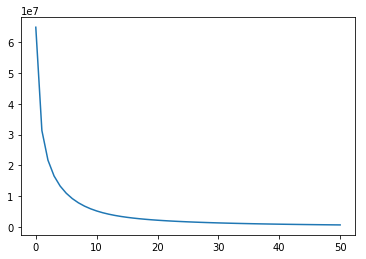

In [19]:
import matplotlib.pyplot as plt
plt.plot(sses)

In [20]:
user_mat

array([[-0.12725234,  0.50928858,  0.4667495 , ...,  0.20907794,
         0.49913015,  0.38070214],
       [-0.23178207, -0.02162758,  0.348095  , ...,  0.15107088,
         0.64499811,  0.67938603],
       [ 0.19587909, -0.13240439,  0.55586147, ...,  0.19797124,
        -0.18127205,  0.39704914],
       ...,
       [ 0.25298504, -0.17454342,  0.21100782, ..., -0.14816107,
         0.29889494,  0.29715762],
       [ 0.1385558 ,  0.05331599,  0.43159521, ...,  0.4156828 ,
         0.0151562 ,  0.69216025],
       [-0.37984937,  0.30994678,  0.36319402, ...,  0.39210579,
        -0.26400189, -0.29703153]])

In [21]:
movie_mat

array([[ 0.13379546,  0.75610661,  0.47479149, ...,  0.92160923,
         0.87487944,  0.78972778],
       [ 0.18312248,  0.76041256,  0.30811496, ...,  0.63085982,
         0.84700586,  0.90869791],
       [-0.27117648,  0.21406857,  0.51475761, ...,  0.80809598,
         0.35069187,  0.60089736],
       ...,
       [-0.13329153, -0.05887408, -0.15112348, ...,  0.75600406,
         0.54521399,  0.42298567],
       [ 0.17552929,  0.76391548, -0.1412335 , ...,  0.09491988,
         0.06215751,  0.53145894],
       [-0.35100988,  0.58554843,  0.39590181, ...,  0.46642639,
         0.62283223,  0.70228512]])

In [22]:
recommendations = np.dot(user_mat, movie_mat)
print(recommendations)
print(targets)

[[ 5.24575315e-01  1.60627531e+00  4.07703788e-01 ...  1.59065265e+00
   1.11170026e+00  2.17205879e+00]
 [ 2.55221512e+00  9.62621045e+00  6.85656662e+00 ...  1.13655851e+01
   1.10638843e+01  1.16318021e+01]
 [ 2.06330331e+00  6.65105070e+00  3.57939249e+00 ...  8.54472929e+00
   8.11659913e+00  8.19794674e+00]
 ...
 [-5.80510206e-01  2.00682113e+00  9.22583416e-01 ...  1.82761779e+00
   1.40495728e+00  1.00658306e+00]
 [ 1.39335419e+00  8.39137832e+00  7.26404134e+00 ...  1.13212803e+01
   1.24533645e+01  1.19961231e+01]
 [ 1.11286441e-01  1.11870372e+00 -1.24916971e-03 ...  6.48706676e-01
  -1.79016903e-01  1.25067168e+00]]
[[0.8 0.8 0.8 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.5 0.4 0.  ... 0.  0.  0. ]
 [0.6 0.  0.  ... 0.  0.  0. ]
 [1.  0.  1.  ... 0.6 0.7 0.7]]


In [23]:
user_mat.shape

(610, 100)

In [24]:
def user_recs(rec_matrix):
    # output user, 4+ rated movies, recommended movies
    liked = targets == 1
    recs = rec_matrix >= 1
    n_users = 2
    for i in range(n_users):
        user_id = idx_to_uid.get(i)

        liked_movies = list()
        rec_movies = list()
        for j in range(n_movies):
            # add to liked?
            if liked[i][j]:
                mvid = idx_to_mvid.get(j)
                liked_movies.append(mvid_to_title.get(mvid))
            if recs[i][j]:
                mvid = idx_to_mvid.get(j)
                rec_movies.append(mvid_to_title.get(mvid))
        
        print('user', user_id)
        print('liked:', liked_movies)
        print('\n')
        print('recs:', rec_movies[:10])
        

In [25]:
user_recs(recommendations)

user 1
liked: ['Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)', 'Bottle Rocket (1996)', 'Rob Roy (1995)', 'Canadian Bacon (1995)', 'Desperado (1995)', 'Billy Madison (1995)', 'Dumb & Dumber (Dumb and Dumber) (1994)', 'Star Wars: Episode IV - A New Hope (1977)', 'Tommy Boy (1995)', 'Jungle Book, The (1994)', 'Fugitive, The (1993)', "Schindler's List (1993)", 'Tombstone (1993)', 'Pinocchio (1940)', 'Fargo (1996)', 'James and the Giant Peach (1996)', 'Wizard of Oz, The (1939)', 'Citizen Kane (1941)', 'Adventures of Robin Hood, The (1938)', 'Mr. Smith Goes to Washington (1939)', 'Winnie the Pooh and the Blustery Day (1968)', 'Three Caballeros, The (1945)', 'Sword in the Stone, The (1963)', 'Dumbo (1941)', 'Bedknobs and Broomsticks (1971)', 'Alice in Wonderland (1951)', 'Ghost and the Darkness, The (1996)', 'Willy Wonka & the Chocolate Factory (1971)', "Monty Python's Life of Brian (1979)", 'Reservoir Dogs (1992)', 'Basic Instinct (1992)', 'E.T. the Extra-Terrestrial (1982)', 'M